# Projekt LLM 25L - Klasyfikacja tekstu na wybranym zbiorze danych poprzez ekstrakcję cech metodą TF-IDF i wytrenowanie (własnego?) klasyfikatora

## Adam Kraś 325177

In [24]:
import torch
import datasets
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!nvidia-smi

Fri May 30 22:25:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P3             10W /   55W |       3MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Wczytanie wybranego zbioru danych
dataset = datasets.load_dataset("community-datasets/yahoo_answers_topics")

In [6]:
dataset["train"][420]  # Wyświetlenie przykładu z zestawu danych

{'id': 420,
 'topic': 4,
 'question_title': 'Who invented the mouse?',
 'question_content': '',
 'best_answer': 'According to the bible, it was God.\\nAccording to Darwin, it was natural evolution.\\nMany others will convince you that it was Steve Jobs and Apple.\\n\\nThe answer, according to http://www.superkids.com/aweb/pages/features/mouse/mouse.html, is Doug Engelbart.\\n\\n(which I found via this Yahoo! Search http://myweb2.search.yahoo.com/search?p=who+invented+the+mouse.)'}

### Analiza zbioru danych została przeprowadzona przed dostrajaniem modelu [BERT](BERT_klasyfikacja.ipynb), tutaj jedynie załaduję zbiór danych w identyczny sposób

In [7]:
train_dataset = dataset["train"]

# dataset_size = 500000

# reduced_train = train_dataset.train_test_split(
#     train_size=dataset_size,
#     test_size=dataset_size // 5,
#     stratify_by_column="topic",
#     shuffle=True,
#     seed=42
# )["train"]

# train_dataset = reduced_train

full_split = train_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = full_split["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = full_split["train"]
val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

# Sprawdzenie rozmiarów zbiorów danych po podziale
print(f"Dataset size: {len(train_dataset) + len(test_dataset) + len(val_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Validation dataset size: {len(val_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")

Dataset size: 1400000
Train dataset size: 80.00%
Test dataset size: 10.00%
Validation dataset size: 10.00%


In [ ]:
def join_text(example):
    return example["question_title"] + " " + example["question_content"]

# Extracting text and labels separately
train_texts = [join_text(example) for example in train_dataset]
test_texts = [join_text(example) for example in test_dataset]
val_texts = [join_text(example) for example in val_dataset]

# Encoding labels
train_labels = [example["topic"] for example in train_dataset]
val_labels = [example["topic"] for example in val_dataset]
test_labels = [example["topic"] for example in test_dataset]

In [34]:
all_topic_names = train_dataset.features["topic"].names

In [17]:
# Rozmiar słownika taki sam jak w BERT
vocab_size = 100000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.9,
)

In [18]:
train_tfidf_texts = vectorizer.fit_transform(train_texts)
val_tfidf_texts = vectorizer.transform(val_texts)
test_tfidf_texts = vectorizer.transform(test_texts)

In [15]:
classifier = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1,
)
classifier.fit(train_tfidf_texts, train_labels)

/home/kraskoa/Templates/25L/LLM/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)

In [16]:
val_preds = classifier.predict(val_tfidf_texts)

print(f"Validation accuracy of Logistic Regression: {accuracy_score(val_labels, val_preds) * 100:.2f}%")

Validation accuracy of Logistic Regression: 71.31%


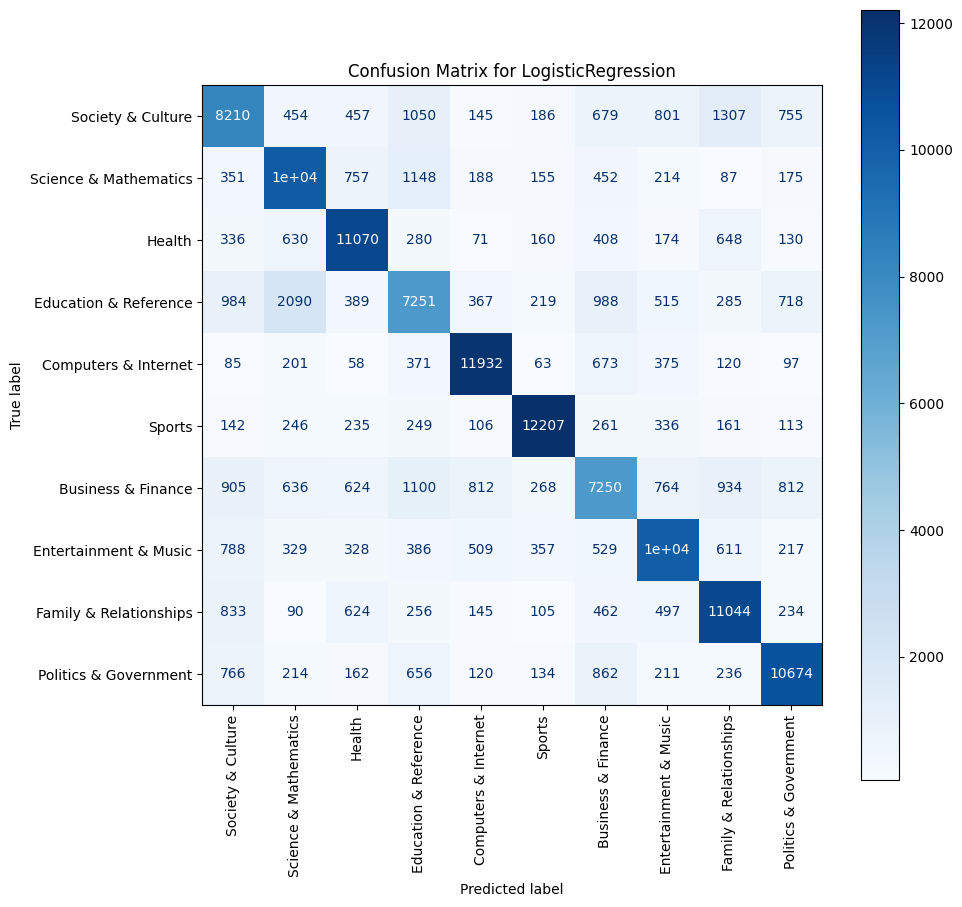

In [35]:
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_topic_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation=90, ax=ax, cmap="Blues")
plt.title("Confusion Matrix for LogisticRegression")
plt.show()

In [22]:
# Now, let's also compare it with OneVsRestClassifier that uses 10 Logistic Regression classifiers
base_classifier = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1,
)
ovr_classifier = OneVsRestClassifier(base_classifier, n_jobs=-1)
ovr_classifier.fit(train_tfidf_texts, train_labels)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                    n_jobs=-1)

In [20]:
val_ovr_preds = ovr_classifier.predict(val_tfidf_texts)
print(f"Validation accuracy of OneVsRestClassifier: {accuracy_score(val_labels, val_ovr_preds) * 100:.2f}%")

Validation accuracy of OneVsRestClassifier: 71.08%
